In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm

%matplotlib notebook

In [2]:
def create_gaussian_J(N, p=1, gb=0, g=1):
    
    '''
    returns a random Gaussian weighted connectivity matrix
    
    N: number of neurons
    p: connectivity probability
    gb: mean connectivity strength (unnormalized)
    g: std of connectivity strength (unnormalized)\
    
    '''
     
    Prob = [p, 1-p] # connection probability
    Size = [N, N]
    ConnMat = np.random.choice([1, 0], size=Size, p=Prob)
    
    mu    = gb/N
    sigma = g/np.sqrt(N)
    GaussMat =  np.random.normal(mu, sigma, size=Size)
    
    J = np.multiply(ConnMat, GaussMat)
    
    return(J)



def create_gaussian_I(N, mu=0, sigma=1, t=1):
    
    '''
    returns a random Gaussian vector I
    
    N: number of neurons
    mu: mean strength
    sigma: std of strength
    t = number of time steps
    '''
    
    if t==1:
        I =  np.random.normal(mu, sigma, size=N)
    else:
        I =  np.random.normal(mu, sigma, size=(N,t))
    
    return(I)
    

In [3]:
class Neurons:
    
    # number of neurons
    N = 10000
    
    # simulation time steps
    T = 100
    
    # learning rate
    alpha = 0.1
    
    #-------------------------------------------------#
    # thalamic neurons
    S_T = np.random.choice([1, -1], size=N)
    # striatal neurons
    S_S = np.random.choice([1, -1], size=N)
    
    # connectivity matrices
    J_ST = create_gaussian_J(N)
    J_TS = create_gaussian_J(N) 
    
    # input to thalamus
    I_T = create_gaussian_I(N)

In [4]:
def update_Neurons(Neurons, update_input=False, update_connectivity=False):
    
    # updating input
    if update_input:
        Neurons.I_T = create_gaussian_I(Neurons.N)
    
    # calculating new states of neurons
    S_T = np.sign(Neurons.I_T + np.matmul(Neurons.J_TS, Neurons.S_S))
    S_S = np.sign(np.matmul(Neurons.J_ST, Neurons.S_T))
    
    # updating connectivity matrices
    if update_connectivity:
        Neurons.J_ST += Neurons.alpha/Neurons.N * np.outer(S_S, Neurons.S_T)
        
    # updating neurons
    Neurons.S_T = S_T
    Neurons.S_S = S_S

    
def rasterplot(S):
    
    S_positions_mat = np.where(S>0)
    time_positions = S_positions_mat[1][:,np.newaxis]
    neuron_no = S_positions_mat[0]
    
    fig, axs = plt.subplots(1,1)
    axs.eventplot(time_positions, lineoffsets=neuron_no, linelengths = 0.9)
    plt.xlabel('time steps')
    plt.ylabel('neuron no.')
    plt.show()


def histplot(S, n=20):
    
    S_rate = np.sum(S>0, 1)/Neurons.T
    
    plt.figure()
    plt.hist(S_rate, n, density=True)
    plt.ylabel('PDF')
    plt.xlabel('firing rate')
    plt.xlim([-0.05, 1.05])
    

def overlap(S1, S2):
    'returns normalized overlap of two matrices as a function of time'
    
    N = S1.shape[0]
    A = np.diag(np.matmul(S1.transpose(), S2))/N
    return(A)


def crosscorr(S1, S2):
    'returns normalized average cross correlation of two matrices as a function of time offsets'
    
    N = S1.shape[0]
    A = np.matmul(S1.transpose(), S2)/N
    offsets = np.arange(-N+1, N-1)
    crosscorr = np.zeros(len(offsets))
    
    for ind,offset in enumerate(offsets):
        diag_terms = np.diag(A, k=offset)
        crosscorr[ind] = np.sum(diag_terms)/len(diag_terms)
        
    return(offsets, crosscorr)
        

## dynamics without plasticity

In [5]:
# Dynamics

S_T = np.zeros((Neurons.N, Neurons.T))
S_S = np.zeros((Neurons.N, Neurons.T))


for ind in tqdm(range(Neurons.T)):
    
    S_T[:, ind] = Neurons.S_T
    S_S[:, ind] = Neurons.S_S
    
    update_Neurons(Neurons, update_input=False, update_connectivity=False)
    

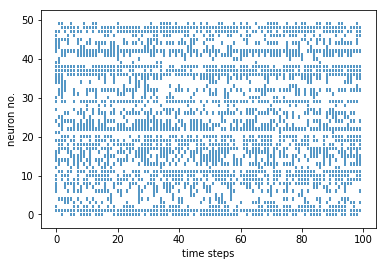

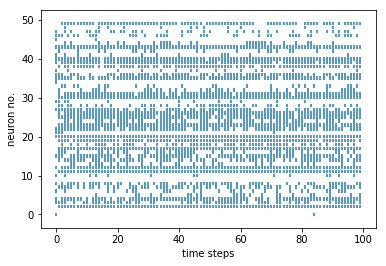

In [6]:
rasterplot(S_S[:50, :])
rasterplot(S_T[:50, :])

## dynamics with plasticity

In [7]:
# Dynamics

S_T = np.zeros((Neurons.N, Neurons.T))
S_S = np.zeros((Neurons.N, Neurons.T))
J_0 = Neurons.J_ST.copy()

for ind in tqdm(range(Neurons.T)):
    
    S_T[:, ind] = Neurons.S_T
    S_S[:, ind] = Neurons.S_S
    
    if ind==int(Neurons.T/2):
        J_1 = Neurons.J_ST.copy()
    
    update_Neurons(Neurons, update_input=False, update_connectivity=True)
    
J_2 = Neurons.J_ST.copy()

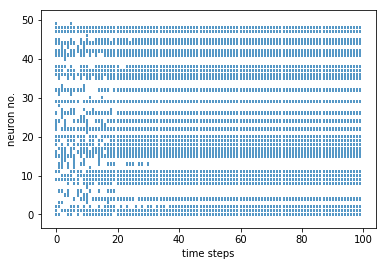

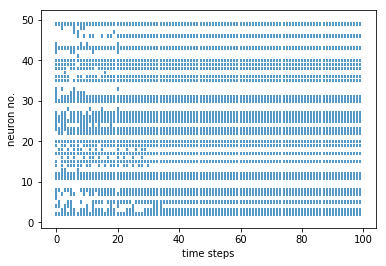

In [8]:
rasterplot(S_S[:50, :])
rasterplot(S_T[:50, :])

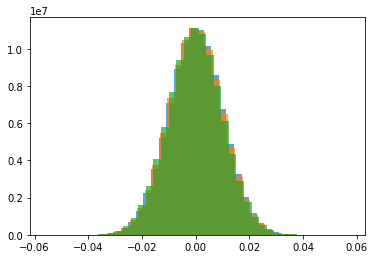

In [9]:
plt.figure()
plt.hist(J_0.flatten(), 40, alpha=0.7);
plt.hist(J_1.flatten(), 40, alpha=0.7);
plt.hist(J_2.flatten(), 40, alpha=0.7);

## connectivity strength effect

<IPython.core.display.Javascript object>


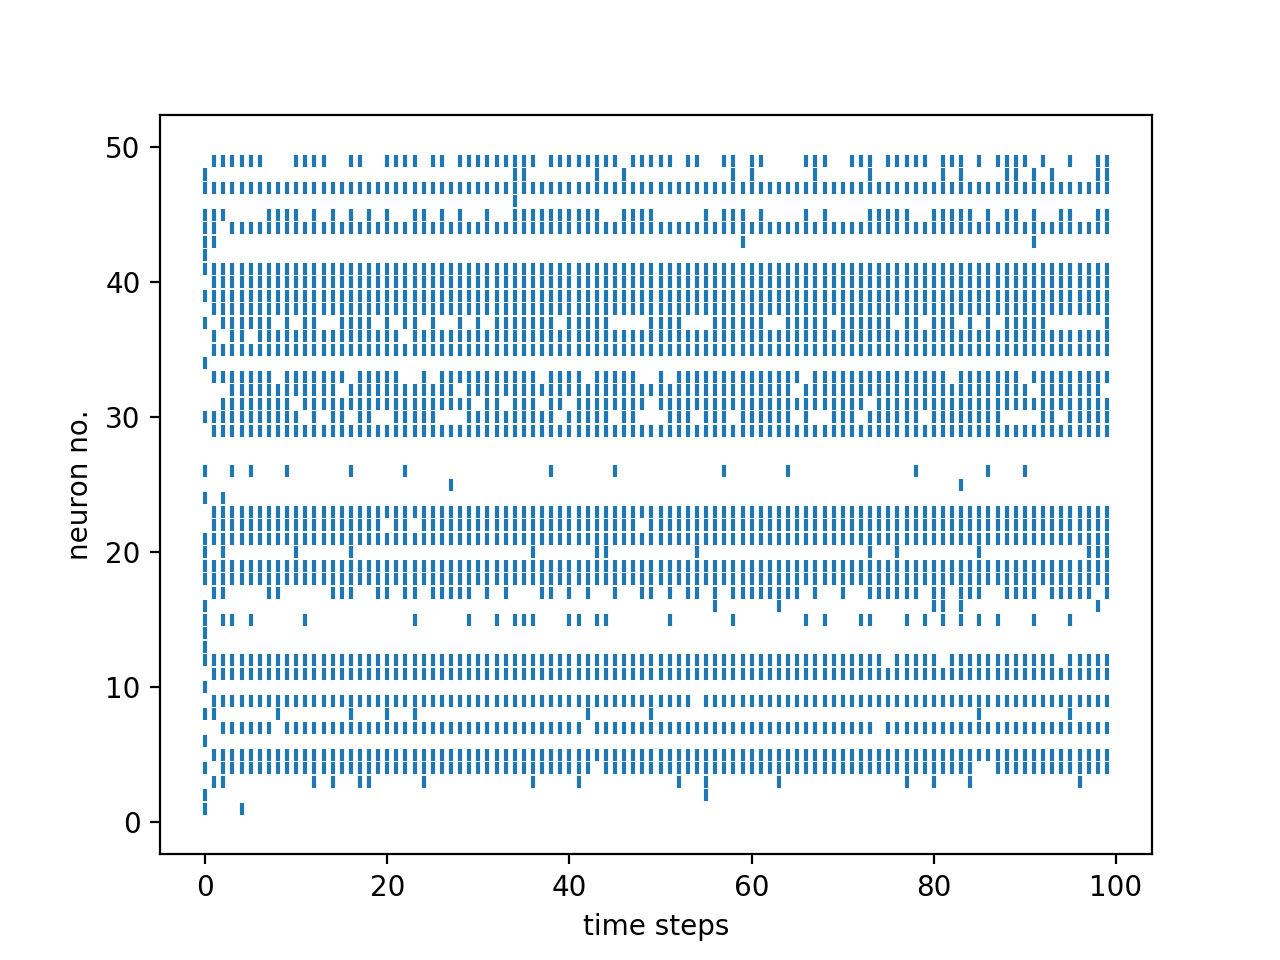

<IPython.core.display.Javascript object>


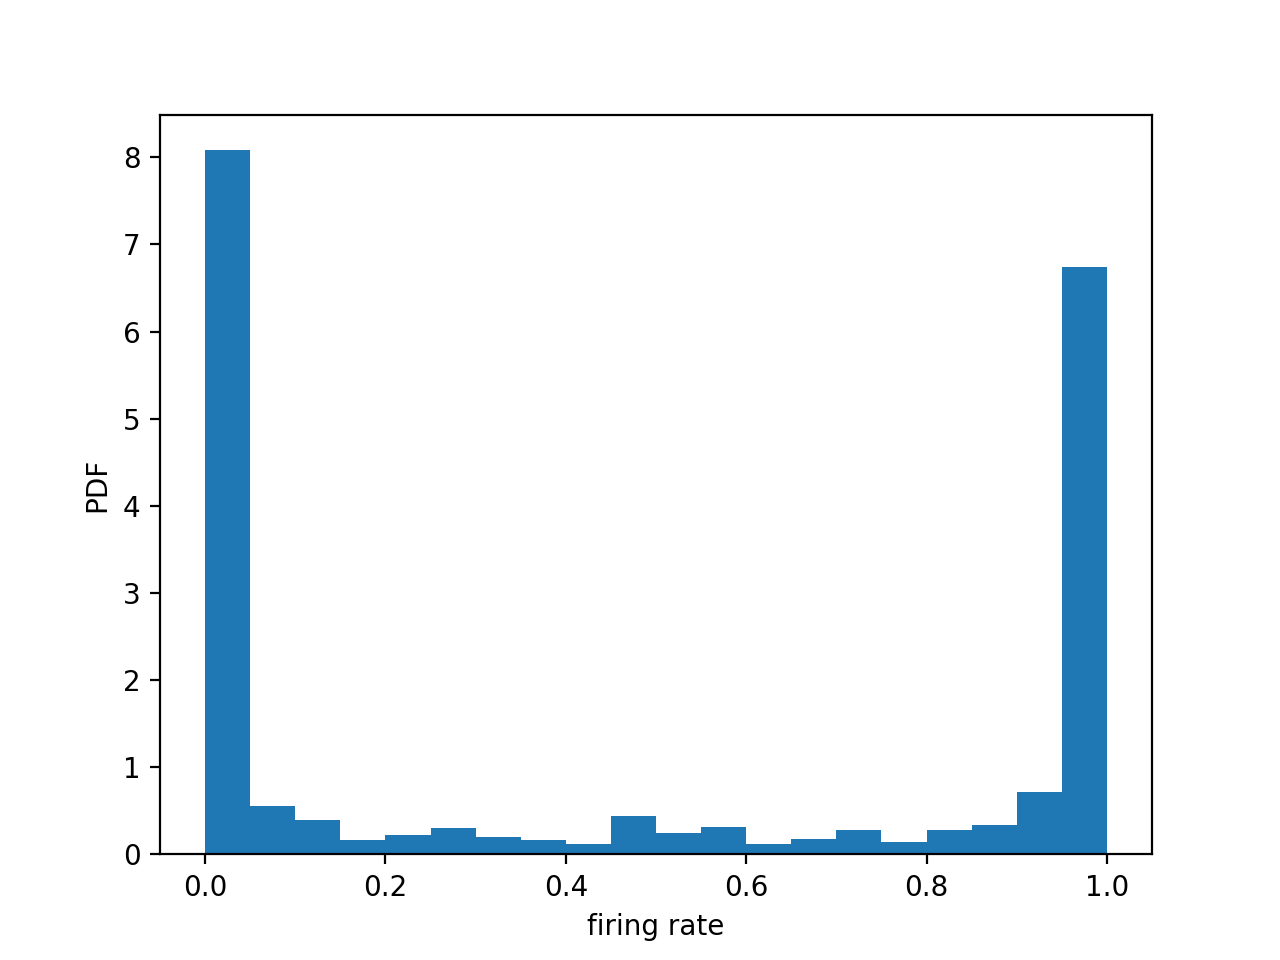

In [184]:
# weak connectivity

Neurons.J_ST = create_gaussian_J(Neurons.N, g=0.1)
Neurons.J_TS = create_gaussian_J(Neurons.N, g=0.1)

S_T = np.zeros((Neurons.N, Neurons.T))
S_S = np.zeros((Neurons.N, Neurons.T))


for ind in tqdm(range(Neurons.T)):
    
    S_T[:, ind] = Neurons.S_T
    S_S[:, ind] = Neurons.S_S
    
    update_Neurons(Neurons, update_input=False, update_connectivity=False)
    
rasterplot(S_S[:50,:100])
histplot(S_S)

## Reproducing a sequence

In [343]:
# creating template sequence

I_t = create_gaussian_I(Neurons.N, sigma=1, t=Neurons.T)

Neurons.J_ST = create_gaussian_J(Neurons.N, g=0.1)
Neurons.J_TS = create_gaussian_J(Neurons.N, g=0.1)

S_T_template = np.zeros((Neurons.N, Neurons.T))
S_S_template = np.zeros((Neurons.N, Neurons.T))


for ind in tqdm(range(Neurons.T)):
    
    Neurons.I_T = I_t[:, ind]
        
    update_Neurons(Neurons, update_input=False, update_connectivity=False)
    S_T_template[:, ind] = Neurons.S_T
    S_S_template[:, ind] = Neurons.S_S
    

In [344]:
# rerunning with the same input

S_T = np.zeros((Neurons.N, Neurons.T))
S_S = np.zeros((Neurons.N, Neurons.T))


for ind in tqdm(range(Neurons.T)):
    
    Neurons.I_T = I_t[:, ind]
        
    update_Neurons(Neurons, update_input=False, update_connectivity=False)
    S_T[:, ind] = Neurons.S_T
    S_S[:, ind] = Neurons.S_S

<IPython.core.display.Javascript object>


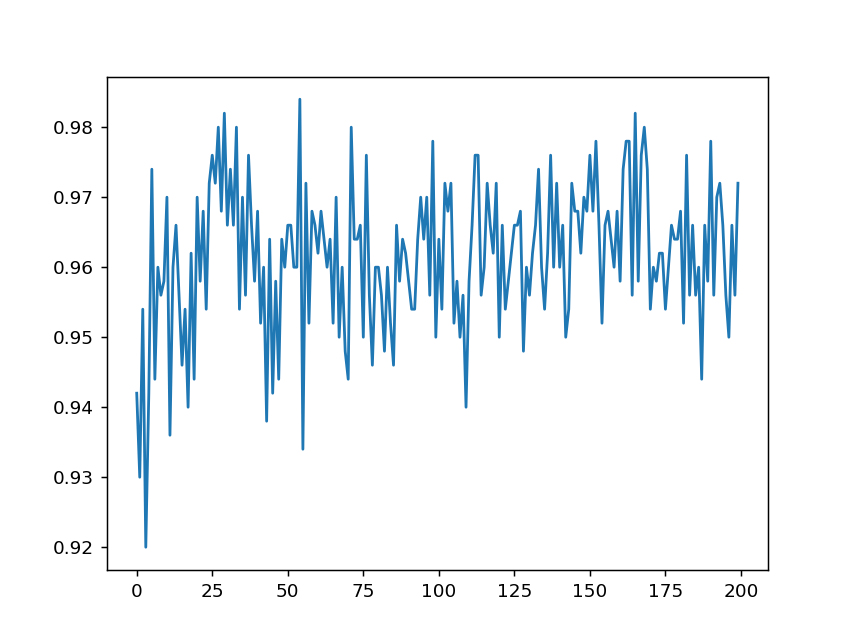

In [345]:
# calclating overlap

A = overlap(S_T, S_T_template)
plt.figure()
plt.plot(A)

<IPython.core.display.Javascript object>


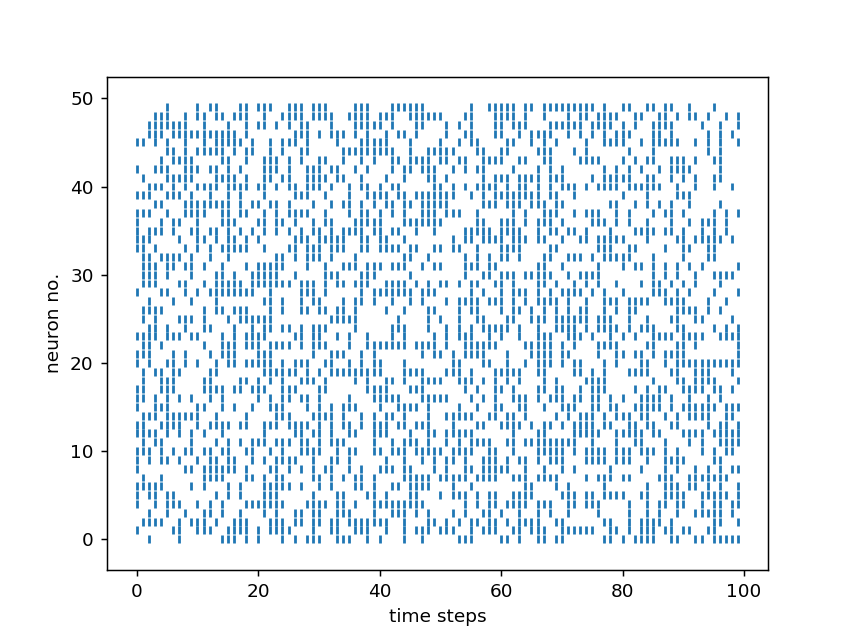

<IPython.core.display.Javascript object>


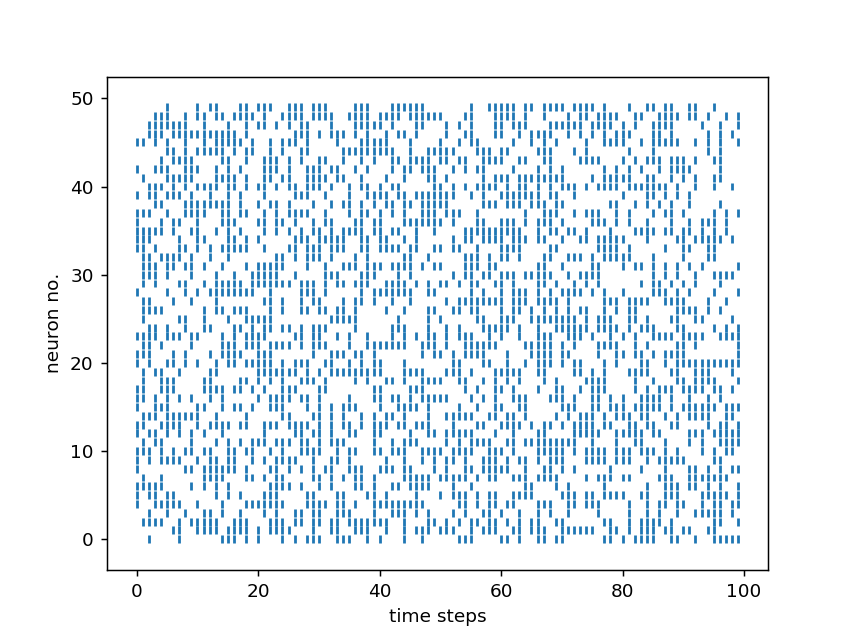

<IPython.core.display.Javascript object>


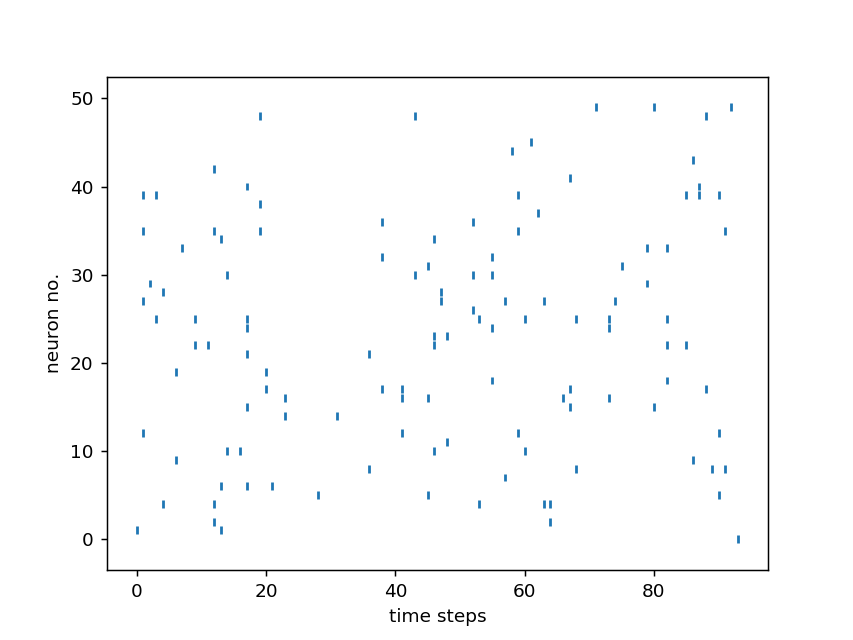

In [346]:
rasterplot(S_T_template[:50,:100])
rasterplot(S_T[:50,:100])

rasterplot(np.abs(S_T[:50,:100]-S_T_template[:50,:100]))



/home/aa293/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


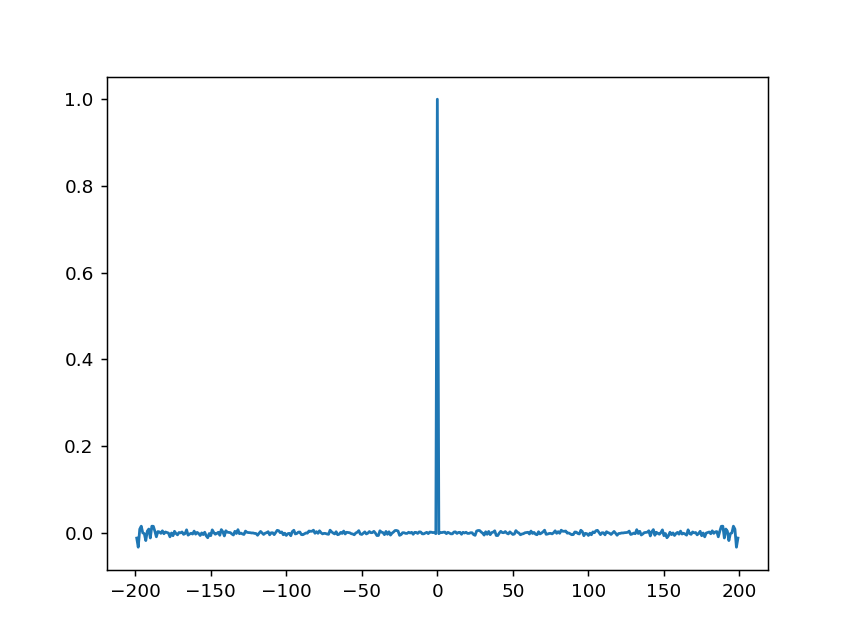

In [316]:
A = crosscorr(S_T, S_T)
plt.figure()
plt.plot(A[0], A[1])

## Learning a sequence

In [10]:
# creating template sequence and learning it

Neurons.alpha = 1 # learning rate

I_t = create_gaussian_I(Neurons.N, sigma=1, t=Neurons.T)

Neurons.J_ST = create_gaussian_J(Neurons.N, g=2)
Neurons.J_TS = create_gaussian_J(Neurons.N, g=2)

S_T_template = np.zeros((Neurons.N, Neurons.T))
S_S_template = np.zeros((Neurons.N, Neurons.T))


for ind in tqdm(range(Neurons.T)):
    
    Neurons.I_T = I_t[:, ind]
        
    update_Neurons(Neurons, update_input=False, update_connectivity=True)
    S_T_template[:, ind] = Neurons.S_T
    S_S_template[:, ind] = Neurons.S_S
    

In [11]:
# rerunning with the same input just for the first time steps

input_strength = 10

S_T = np.zeros((Neurons.N, Neurons.T))
S_S = np.zeros((Neurons.N, Neurons.T))

for ind in tqdm(range(Neurons.T)):
    
    if ind==0:
        Neurons.I_T = I_t[:, 0]*input_strength
    else:
        Neurons.I_T = 0
        
    update_Neurons(Neurons, update_input=False, update_connectivity=False)
    S_T[:, ind] = Neurons.S_T
    S_S[:, ind] = Neurons.S_S

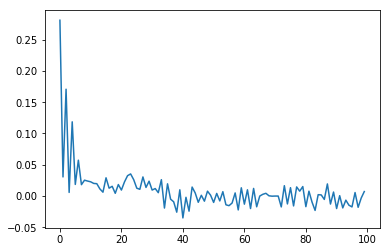

In [12]:
# calclating overlap

A = overlap(S_T, S_T_template)
plt.figure()
plt.plot(A)

<IPython.core.display.Javascript object>


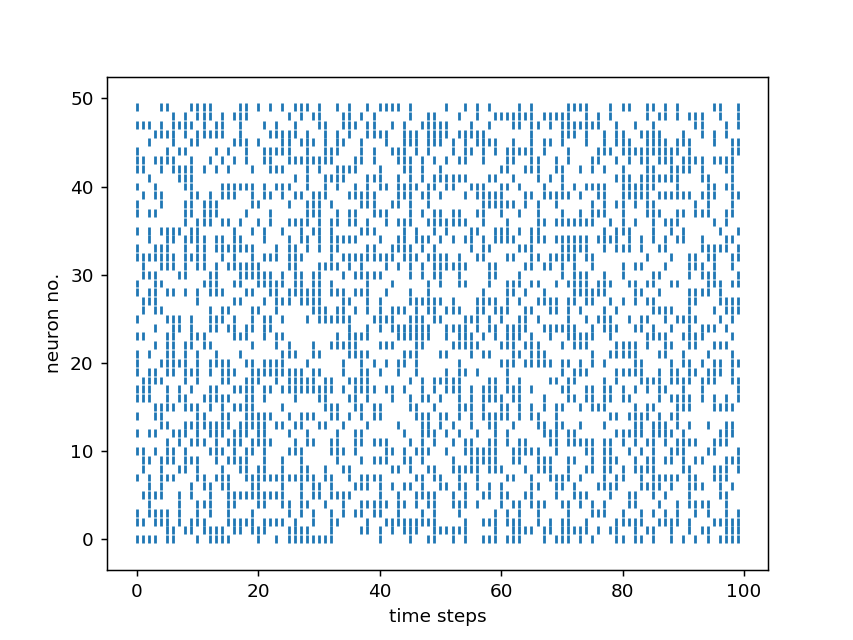

<IPython.core.display.Javascript object>


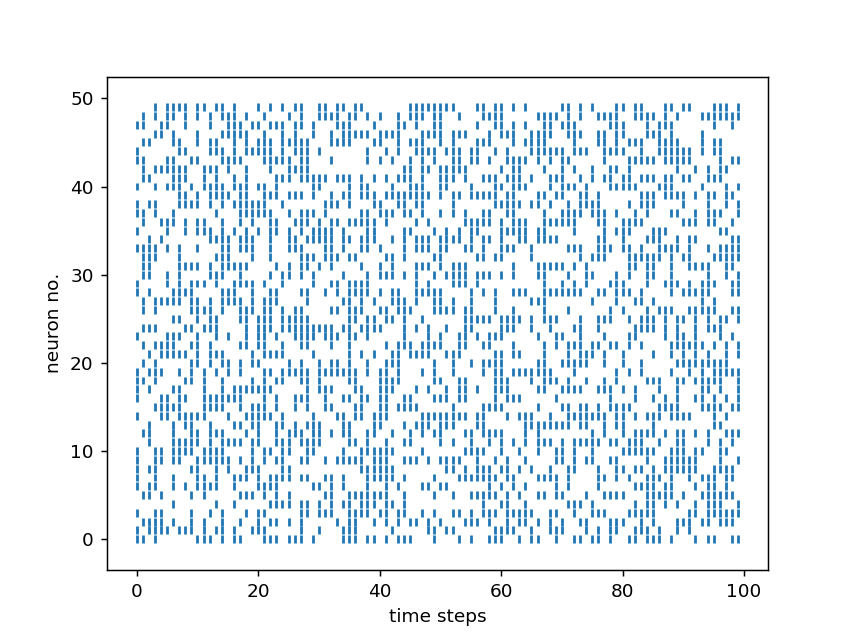

In [378]:
rasterplot(S_T_template[:50,:100])
rasterplot(S_T[:50,:100])

#rasterplot(np.abs(S_T[:50,:100]-S_T_template[:50,:100]))
